# Book recommendation engine

![separator](https://raw.githubusercontent.com/Sithlord-dev/Book_recommendation_engine/main/files/sep.jpeg)

We will create a book recommendation algorithm using Scikit learn's [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html).

We use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) which contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

We use Collaborative Filtering to make our recommendations out based other user's similar preferences. We will use a machine learning algorithm : the NearestNeighbors from sklearn.neighbors to produce book recommendations that are similar (based on user's ratings) to a given book.

In [ ]:
# Data analysis libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, norm
from scipy.sparse import csr_matrix

## Scikit Learn Models:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

## String metrics
import Levenshtein as lev

For visibility reasons, we adobpt the following set of colours : <span style='color:#1e3d59'>#1e3d59</span>, <span style='color:#f5f0e1'>#f5f0e1</span>, <span style='color:#ff6e40'>#ff6e40</span>, <span style='color:#ffc13b'>#ffc13b</span>

In [ ]:
colours = ['#1e3d59', '#f5f0e1', '#ff6e40', '#ffc13b']

### 1. Data analysis:

In [ ]:
# get data files
!wget hhttp://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip

!unzip BX-CSV-Dump.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'
users_filename = 'BX-Users.csv'

We import the files in a `pandas` DataFrame:

In [ ]:
df_books = pd.read_csv(books_filename,
                       encoding = "ISO-8859-1",
                       sep=";",
                       header=0,
                       names=['isbn', 'title', 'author'],
                       usecols=['isbn', 'title', 'author'],
                       dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(ratings_filename,
                         encoding = "ISO-8859-1",
                         sep=";",
                         header=0,
                         names=['user', 'isbn', 'rating'],
                         usecols=['user', 'isbn', 'rating'],
                         dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df_users = pd.read_csv(users_filename,
                         encoding = "ISO-8859-1",
                         sep=";",
                         header=0,
                         names=['user', 'location', 'age'],
                         usecols=['user', 'location', 'age'])

We can start having a look at the age distribution of the users:

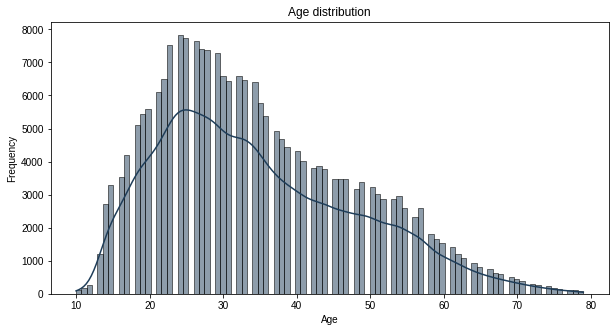

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

#plot:
sns.histplot(data = df_users['age'].dropna()[(df_users['age'].dropna() < 80) & (df_users['age'].dropna() >= 10)], 
             stat = 'frequency', 
             kde = True,
             color = colours[0],
             ax=ax)

# plot infos:
plt.style.use('seaborn-whitegrid')
plt.title('Age distribution')
plt.xlabel('Age');

Most of the active users are between 20 and 30. Let's have a look at the ratings:

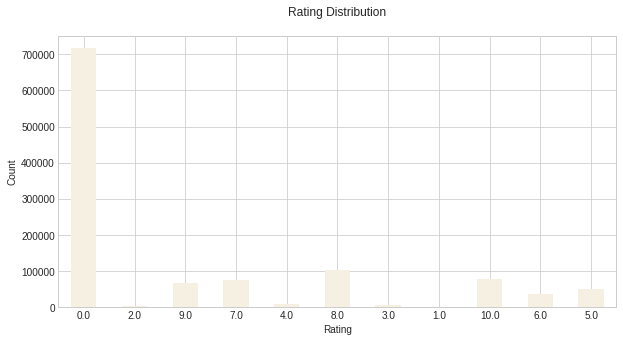

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

#plot:
df_ratings['rating'].value_counts(sort=False).plot(kind='bar',
                                                   color = colours[1],
                                                   ax = ax)

# plot infos:
plt.style.use('seaborn-whitegrid')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0); 

One sees for starters, that the most of the ratings are 0. We can see the TOP 5 rated books:

In [ ]:
df_ratings_books = pd.merge(df_ratings, df_books, on='isbn')

df_ratings_books.sort_values('rating', ascending=False).head(5)

,user,isbn,rating,title,author
68283,273906,3596200261,10.0,"Fischer TaschenbÃ?Â¼cher, Bd.26, SchÃ?Â¶ne neu...",Aldous Huxley
108227,211152,0743203631,10.0,Gap Creek: The Story Of A Marriage,Robert Morgan
619156,240144,0345276469,10.0,Agatha Christie: An Autobiography,Agatha Christie
925376,144194,0446517283,10.0,The Dragon King (Crimson Shadow/R.a. Salvatore),R. A. Salvatore
709904,200300,0525946500,10.0,Charleston,John Jakes


The ratings are very much unevenly distributed, we can also have a look at the number of ratings per user and the number of ratings per book:

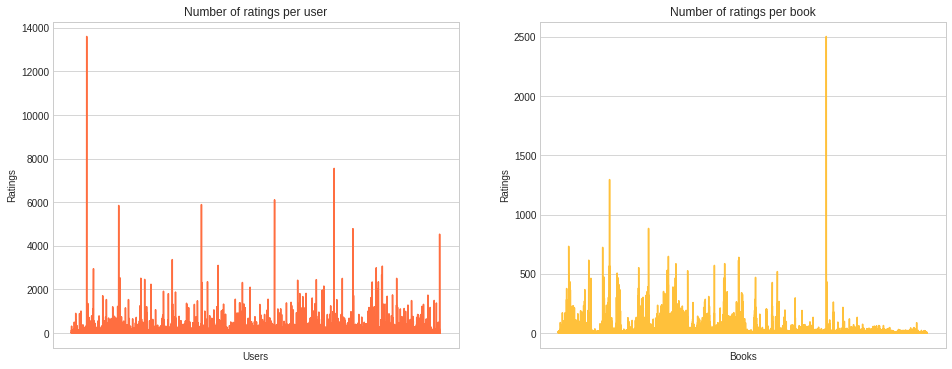

In [ ]:
num_user_ratings = df_ratings.groupby(['user']).count()
num_book_ratings = df_ratings.groupby(['isbn']).count()

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))

#plot:
num_user_ratings['rating'].plot(ax = ax1,
                                color = colours[2]);
num_book_ratings['rating'].plot(ax = ax2,
                                color = colours[3]);
# plot infos:
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_title('Number of ratings per user')
ax2.set_title('Number of ratings per book')
ax1.set_ylabel('Ratings')
ax2.set_ylabel('Ratings')
ax1.set_xlabel('Users')
ax2.set_xlabel('Books');

We can clearly see that the books are not rated frequently. We see few peeks in users, and in books as well. We can have a look at the most rated book or even the 5 most rated books for example: 

In [ ]:
most_rated_books = num_book_ratings.sort_values('rating', ascending=False)
most_rated_books_preview = pd.merge(most_rated_books, df_books, on='isbn').drop('user', axis=1)

most_rated_books_preview.head(5)

,isbn,rating,title,author
0,0971880107,2502,Wild Animus,Rich Shapero
1,0316666343,1295,The Lovely Bones: A Novel,Alice Sebold
2,0385504209,883,The Da Vinci Code,Dan Brown
3,0060928336,732,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
4,0312195516,723,The Red Tent (Bestselling Backlist),Anita Diamant


For a higher statistical significance, we choose to ommit the users with less than 200 ratings, and books with less than 100 ratings:

In [ ]:
ratings = df_ratings

#remove users that have given less than 200 ratings
users_count = ratings['user'].value_counts()
ratings = ratings[~ratings['user'].isin(users_count[users_count < 200].index)]

# remove books that have been rated less than 100 times.
books_count = ratings['rating'].value_counts()
ratings = ratings[~ratings['isbn'].isin(books_count[books_count < 100].index)]

**Note :** It turns out that the most rated book has one of the lowest rating average: This makes sense somehow, people tend to rate a lot or books they love, or books they hate.

In [ ]:
num_book_ratings['average rating'] = df_ratings.groupby('isbn')['rating'].mean()

pd.merge(num_book_ratings, df_books[['title', 'isbn']], on='isbn').sort_values('rating', ascending=False).head()

,isbn,user,rating,average rating,title
215968,0971880107,2502,2502,1.019584,Wild Animus
38572,0316666343,1295,1295,4.468726,The Lovely Bones: A Novel
70803,0385504209,883,883,4.652322,The Da Vinci Code
7345,0060928336,732,732,3.448087,Divine Secrets of the Ya-Ya Sisterhood: A Novel
32372,0312195516,723,723,4.334716,The Red Tent (Bestselling Backlist)


#### Correlation:

In [ ]:
import warnings

warnings.filterwarnings("ignore",category =RuntimeWarning)

We use bivariate correlation or PCC ([Pearson's correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) in order to calculate the (linear) correlation between two ratings:

In [ ]:
# pivot ratings into matrix style
df_ratings_mtrx = ratings.pivot(index='user',
                                   columns='isbn',
                                   values='rating')

As someone who has read *The Da Vinci Code* (with `isbn = 0385504209`), let's try and see corrolated results that Aearson's coefficient suggests:

In [ ]:
davinci_corr = pd.DataFrame(df_ratings_mtrx.corrwith(df_ratings_mtrx['0385504209'], method='pearson'), columns=['pearson coeff']).dropna()

We can observe the top 10 suggestions whose ratings are highly corrolated to the ones of the *Da Vinci Code* :

In [ ]:
davinci_corr_preview = pd.merge(davinci_corr, num_book_ratings[(num_book_ratings['rating'] >= 500)], on="isbn").drop('user',axis = 1)

pd.merge(davinci_corr_preview, df_books[["title","isbn"]], on="isbn").sort_values('pearson coeff', ascending=False).head(10)

,isbn,pearson coeff,rating,average rating,title
7,0385504209,1.000000,883,4.652322,The Da Vinci Code
15,0671027360,0.218741,586,3.718430,Angels &amp; Demons
6,0375727345,0.214953,552,3.039855,House of Sand and Fog
1,0142001740,0.186145,615,4.219512,The Secret Life of Bees
16,067976402X,0.179512,614,3.255700,Snow Falling on Cedars
14,059035342X,0.166290,571,4.900175,Harry Potter and the Sorcerer's Stone (Harry P...
5,0345337662,0.149289,506,3.535573,Interview with the Vampire
4,0316666343,0.143711,1295,4.468726,The Lovely Bones: A Novel
12,0446672211,0.135783,585,4.105983,Where the Heart Is (Oprah's Book Club (Paperba...
3,0316601950,0.133880,568,3.593310,The Pilot's Wife : A Novel


This suggests that the correlation does work indeed, as we have a first suggestion that is from the same author, and the fours others are all Mystery/Thrillers genre.

### 2. Data modelling:

We convert our DataFrame into a `scipy` [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix#Symmetric) and fill the missing values with zeros (since we actually will calculate distances between rating vectors)

In [ ]:
df_ratings_books = pd.merge(ratings, df_books, on='isbn').dropna(axis = 0, subset = ['title']).drop_duplicates(['user', 'title'])
df_ratings_books_mtrx = df_ratings_books.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)

# convert dataframe to scipy sparse matrix for more efficient calculations
ratings_mtrx = csr_matrix(df_ratings_books_mtrx.values)

We use the k-nearest neighbors algorithm from `KNN`: We choose the `metric=cosine` to calculate thr cosine similarity between rating vectors

In [ ]:
model = NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                         metric_params=None, n_jobs=1, n_neighbors=5, p=2,).fit(ratings_mtrx)
model

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=1)

We write a function that would use our model to give the 5 most pertinent recommendations given a title book:

In [ ]:
def get_recommends(book = "", verbose=False):
    """ Take the title of a book and checks if it is in the database, then prints 5 recommendations using KNN and returns a list of
    each recommendation with its distance, if verbose is set, it also prints the distances"""
    try:
        index = df_ratings_books_mtrx.index.get_loc(book)
    except:
        print("Couldn't find any :'(")
        return [book, ["", 0.]*5]
    
    knn_dist, knn_ind = model.kneighbors(df_ratings_books_mtrx.iloc[index, :].values.reshape(1, -1), n_neighbors = 6)
    recommendations = [book, []]

    for i in range(0, len(knn_dist.flatten())):
        if i == 0:
            book_to_recommand = df_ratings_books_mtrx.index[index]
            print('Recommendations for {}:\n'.format(book_to_recommand))
        else:
            book_to_recommand = df_ratings_books_mtrx.index[knn_ind.flatten()[i]]
            recommendations[1].append([book_to_recommand, knn_dist.flatten()[i]])
            if verbose:
                print('{}: {}, with a distance of {:.4f}'.format(i, book_to_recommand, knn_dist.flatten()[i]))
            else :
                print('{}: {}'.format(i, book_to_recommand))
    return recommendations

And we test it: here I picked the same book *The Da Vinci Code* from the green Mile series

In [ ]:
get_recommends(book = "The Da Vinci Code");

Recommendations for The Da Vinci Code:

1: Angels &amp; Demons
2: Widow's Walk
3: Doing Good
4: The Blue Nowhere : A Novel
5: Touching Evil


As a bonus, we write a function that would help us, using the [Jaro distance](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance) to compare the similitudes between two chain of strings. We use the module [Levenshtein](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html#Levenshtein-distance) for a very fast computation:

In [ ]:
def title_suggest(title, lst=list(dict.fromkeys(list(df_books['title']))), k=20):
    """Gives available suggestions of books in the database based on the Jaro distance for string matching"""

    comp = list()
    for name in lst:
        comp.append((name, lev.jaro(title, name)))
    comp.sort(key=lambda x:x[1], reverse = True)
    print("Possible suggestions:")
    for i in range(k):
        print(comp[i][0])
    return comp[:5]

And we try to get suggestions, say *memoirs of a Geisha*:

In [ ]:
title_suggest("Memoirs of a Geisha");

Possible suggestions:
Memoirs of a Geisha
Memoirs of a Geisha Uk
Memoirs of a Beatnik
Memoirs of a Pet Therapist
Memoirs of Elise
Memoirs of the Forties
Memoirs of an Invisible Man
Memoirs of a Medieval Woman
Memoirs of a Geisha : A Novel (AUDIO CASSETTE)
Memoirs of a Survivor
Memoirs of Fanny Hill
Memoirs of a Race Traitor
Memoirs
Memoirs of an Unfit Mother
Memoirs of a Bengal Civilian
Memoirs of a Mangy Lover
Promise of Paradise
Memoirs of a Voluptuary
Memoirs of a Lightkeeper's Son
Memoirs of a Dutiful Daughter


In [ ]:
get_recommends(book="Memoirs of a Geisha Uk", verbose=True);

Recommendations for Memoirs of a Geisha Uk:

1: White Horses, with a distance of 0.4897
2: The Peppered Moth, with a distance of 0.4906
3: Larrys Party, with a distance of 0.4936
4: Most Secret, with a distance of 0.5407
5: Billy, with a distance of 0.5496


The function `title_suggest` can be implemented in the function `get_recommends` in the case where no title matched the input title.